In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

In [2]:
def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))
def logsumexp(a, axis=None, b=None, keepdims=False, return_sign=False):
    
    a = _asarray_validated(a, check_finite=False)
    if b is not None:
        a, b = np.broadcast_arrays(a, b)
        if np.any(b == 0):
            a = a + 0.  # promote to at least float
            a[b == 0] = -np.inf

    a_max = np.amax(a, axis=axis, keepdims=True)

    if a_max.ndim > 0:
        a_max[~np.isfinite(a_max)] = 0
    elif not np.isfinite(a_max):
        a_max = 0

    if b is not None:
        b = np.asarray(b)
        tmp = b * np.exp(a - a_max)
    else:
        tmp = np.exp(a - a_max)

    # suppress warnings about log of zero
    with np.errstate(divide='ignore'):
        s = np.sum(tmp, axis=axis, keepdims=keepdims)
        if return_sign:
            sgn = np.sign(s)
            s *= sgn  # /= makes more sense but we need zero -> zero
        out = np.log(s)

    if not keepdims:
        a_max = np.squeeze(a_max, axis=axis)
    out += a_max

    if return_sign:
        return out, sgn
    else:
        return out
def _asarray_validated(a, check_finite=True,
                       sparse_ok=False, objects_ok=False, mask_ok=False,
                       as_inexact=False):
    if not sparse_ok:
        import scipy.sparse
        if scipy.sparse.issparse(a):
            msg = ('Sparse matrices are not supported by this function. '
                   'Perhaps one of the scipy.sparse.linalg functions '
                   'would work instead.')
            raise ValueError(msg)
    if not mask_ok:
        if np.ma.isMaskedArray(a):
            raise ValueError('masked arrays are not supported')
    toarray = np.asarray_chkfinite if check_finite else np.asarray
    a = toarray(a)
    if not objects_ok:
        if a.dtype is np.dtype('O'):
            raise ValueError('object arrays are not supported')
    if as_inexact:
        if not np.issubdtype(a.dtype, np.inexact):
            a = toarray(a, dtype=np.float_)
    return a

In [3]:
def bit_to_list(t, n):
    S = [0 for i in range(n)]    
    i = -1
    while t != 0:
        S[i] = t % 2
        t = t >> 1
        i -= 1
    return S

In [4]:
def action_generator(n):
    """
    action space: 2^n, only depends on # agents
    
    input: 
        number of agents
    return: 
        maximum action space for a state
    """

    action = dict()
    nA = 2**n
    for a in range(nA):
        action[a] = bit_to_list(a, n) # 4 means # agents
    return action

In [5]:
def state_generator2(graph, n, node_N):
    """
    global state space: [#agents, \forall nodes]
                        (node_N - 2) / 2 * (n + 1)
    this function is used to generate the feasible graph
    input:
        node_N: # nodes
        n: number of agents
    return:
        global state space: [#agents, \forall nodes]
        
    """
    r_ = (node_N - 4) / 4
    
    node_n = len(graph) # in the original graph
    nS = int(2 + ((node_N - 2)/2) * (n + 1))
    state = np.zeros((nS, node_N))
    mark = node_n - 2
    
    
    # 0, -1
    state[0][0] = n
    state[-1][-1] = n
    
    # repeat 
    i = 0 
    m = 1
    for s in range(1, (nS-1)):
        state[s][m] =  i 
        state[s][m+1] = n - i
        i += 1
        if i >= (n+1):
            i = 0 
            m += 2
    
    state = state.astype(int)
    return state.tolist()

In [6]:
def transition_generator(state, action, n, node_N):
    """
    transition function: 
    
    """
    
    
    transition = []
    nS = len(state)
    nA = len(action)
    p_reset = np.zeros(node_N)

    # start: all at s

    state_n = np.zeros(nA)
    for a in range(nA):
        s = sum(action[a])
        p_reset[1] = s
        p_reset[2] = n-s
        p_reset= p_reset.astype(int)
        state_n[a] = state.index(p_reset.tolist())
    transition.append(state_n)
    


    p_reset = np.zeros(node_N)
    index = 3
    c = 0
    
    # (node_N - 2) / 4 = repeat
    repeat = int((node_N - 4) / 2)
    for _ in range(repeat): # 
        while c < 3:
            state_n = np.zeros(nA)
            for a in range(nA):
                s = sum(action[a])
                p_reset[index] = s
                p_reset[index+1] = n-s
                p_reset= p_reset.astype(int)
                state_n[a] = state.index(p_reset.tolist())
            transition.append(state_n)
            c += 1
#             print(transition)
        p_reset = np.zeros(node_N)
        index += 2
        c = 0
    
    # at end
    # end = len(state) -1
    state_n = np.zeros(nA) + nS - 1
    for _ in range(n+2):
        transition.append(state_n)
    
    return transition

In [7]:
def phi_generator2( state, action, transition, graph, node_N , n):
    
    """
    # 0  --> down
    # 1  --> up 
    """
    phi = []
    nS = len(state)
    nA = len(action)
    
    # at step 0
    reward = np.zeros(nA)
    for a in range(nA):
        act = action[a]
        s = sum(act) # count how many 1
        part1, part2 = 0, 0
        m, v = 0, 0
        for m in range(s):
            part1 += graph["0"]["1"](m+1)
        for v in range(n-s):
            part2 += graph["0"]["0"](v+1)
        reward[a] = part1 + part2
    phi.append(reward)
    
    
    # at node 1,2
    # repeat = (node_N - 4) / 4
    repeat = int((node_N - 4) / 4)
    for _ in range(repeat):
        for i in range(1,n+2):
            mark = state[i][1]
            reward = np.zeros(len(action))
            for a in range(len(action)):
                act = action[a]
                s = sum(act)

                part1, part2 = 0, 0
                m, v = 0, 0
                s_ = sum(action[a][0:mark])
                for m in range(s_):
                    part1 += graph["1"]["1"](m+1)
                for v in range(mark-s_):
                    part2 += graph["1"]["0"](v+1)

                part3, part4 = 0, 0
                j, w = 0, 0
                s__ = s - s_
                for j in range(s__):
                    part3 += graph["2"]["1"](j+1)
                for w in range(n-mark-s__):
                    part4 += graph["2"]["0"](w+1)
                reward[a] = part1 + part2 + part3 + part4
            phi.append(reward)

        # at node 3, 4
        for i in range(1,n+2):
            mark = state[i][1]
            reward = np.zeros(len(action))
            for a in range(len(action)):
                act = action[a]
                s = sum(act)

                part1, part2 = 0, 0
                m, v = 0, 0
                s_ = sum(action[a][0:mark])
                for m in range(s_):
                    part1 += graph["3"]["1"](m+1)
                for v in range(mark-s_):
                    part2 += graph["3"]["0"](v+1)

                part3, part4 = 0, 0
                j, w = 0, 0
                s__ = s - s_
                for j in range(s__):
                    part3 += graph["4"]["1"](j+1)
                for w in range(n-mark-s__):
                    part4 += graph["4"]["0"](w+1) #
                reward[a] = part1 + part2 + part3 + part4
            phi.append(reward)
#     print(len(phi))
       
#     # at end
#     st, nd = nS-5, nS-2

#     for i in range(st,nd):
#         mark_ = state[i][-3] # to do
#         reward = np.zeros(len(action))
#         a = 0
#         for a in range(len(action)):
#             act = action[a]
#             s = sum(act)
#             zero_c = act[0:mark_].count(0)
#             part1, part2 = 0, 0
#             m, v = 0, 0
#             if (zero_c == mark_) and (s == state[i][-2]):
#                 for m in range(mark_):
#                     part1 += graph["5"]["1"](m)
#                 for v in range(state[i][-2]):
#                     part2 += graph["6"]["1"](v)
#                 reward[a] = part1 + part2
#             else:
#                 reward[a] = 20
#         phi.append(reward)

    phi.append(np.array([2., 20., 20., 20.]))
    phi.append(np.array([20., 2., 2., 20.]))
    phi.append(np.array([20., 20., 20., 3.]))
    # at terminal
    reward = np.zeros(len(action))
    phi.append(reward)

    return phi

In [41]:
# helper function

def value_iteration(itera, theta=0.0001, discount_factor=1.0):
    policy_list = []

    def one_step_lookahead(state, V):
        A = np.zeros(nA)
        for a in range(nA):
            for prob, next_state, reward, done in P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    V = np.zeros(nS)
    iter = 0
    dl = []
    vl = []

    for _ in range(itera):
        iter += 1
        print(iter)
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10.
            V[s] = best_action_value

        vl.append(V.copy())
        dl.append(delta)

        # Check if we can stop
        print("debug-> iter={}, delta={:.5f}, V={}".format(iter, delta, V))
#         if delta < theta:
#             break
        # Create a deterministic policy using the optimal value function
        policy_iter = np.zeros([nS, nA])
        for s in range(nS):
            # One step lookahead to find the best action for this state
            A = one_step_lookahead(s, V)
            # pdb.set_trace()
            policy_t = softmax(A)
            best_action = np.argmax(A)
            # Always take the best action
            # policy_iter[s, best_action] = 1.0
            # soft policy
            policy_iter[s, :] = policy_t # record action values
        policy_list.append(policy_iter)
        # print("policy", policy_iter)

    # Create a deterministic policy using the optimal value function
    policy = np.zeros([nS, nA])
    for s in range(nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        print(A)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0

    return policy, V, dl, vl, policy_list, A

In [55]:
# 2 agents; small
# payoff matrix

nS = 8
nA = 3

payoff = [
    [-3, -3, -4], # [s,s]
    [-2, -2, -3], # [a,a]
    [-2, -2, -2], # [a,b]
    [-2, -2, -3], # [b,b]
    [-3, -10, -10], # [c,c]
    [-10, -2, -10], # [c,d]
    [-10, -10, -2],  # [d,d]
    [0, 0, 0]     # [T,T]
]
transition =[
    [1, 2, 3],
    [4, 5, 6],
    [4, 5, 6],
    [4, 5, 6],
    [7, 7, 7],
    [7, 7, 7],
    [7, 7, 7],
    [7, 7, 7]
]

In [56]:
payoff = np.array(payoff) + 5
payoff[-1, :] = 0
payoff

array([[ 2,  2,  1],
       [ 3,  3,  2],
       [ 3,  3,  3],
       [ 3,  3,  2],
       [ 2, -5, -5],
       [-5,  3, -5],
       [-5, -5,  3],
       [ 0,  0,  0]])

In [3]:
# 2 agents; big
# payoff matrix

nS = 11
nA = 3

payoff = [
    [-3, -3, -4], # [s,s] 1
    [-2, -2, -3], # [a,a] 2
    [-2, -2, -2], # [a,d] 3
    [-2, -2, -3], # [d,d] 4
    [-3, -3, -4], # [b,b] 5
    [-2, -2, -2], # [b,e] 6
    [-2, -2, -2],  # [e,e] 7
    [-3, -10, -10], # [c,c] 8
    [-10, -2, -10], # [c,f] 9
    [-10, -10, -2], # [f,f] 10
    [0, 0, 0]      #[T,T] 11
]
transition =[
    [1, 2, 3],
    [4, 5, 6],
    [4, 5, 6],
    [4, 5, 6],
    [7, 8, 9],
    [7, 8, 9],
    [7, 8, 9],
    [10,10,10],
    [10, 10, 10],
    [10, 10, 10],
    [10, 10, 10]
]

In [57]:
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 10:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, snext, reward, done)])
        P[state][a] = tmp
P

{0: {0: [(1, 1, 2, False)], 1: [(1, 2, 2, False)], 2: [(1, 3, 1, False)]},
 1: {0: [(1, 4, 3, False)], 1: [(1, 5, 3, False)], 2: [(1, 6, 2, False)]},
 2: {0: [(1, 4, 3, False)], 1: [(1, 5, 3, False)], 2: [(1, 6, 3, False)]},
 3: {0: [(1, 4, 3, False)], 1: [(1, 5, 3, False)], 2: [(1, 6, 2, False)]},
 4: {0: [(1, 7, 2, False)], 1: [(1, 7, -5, False)], 2: [(1, 7, -5, False)]},
 5: {0: [(1, 7, -5, False)], 1: [(1, 7, 3, False)], 2: [(1, 7, -5, False)]},
 6: {0: [(1, 7, -5, False)], 1: [(1, 7, -5, False)], 2: [(1, 7, 3, False)]},
 7: {0: [(1, 7, 0, False)], 1: [(1, 7, 0, False)], 2: [(1, 7, 0, False)]}}

In [59]:
policy, V, dl, vl, policy_list, A = value_iteration(10)

1
debug-> iter=1, delta=3.00000, V=[2. 3. 3. 3. 2. 3. 3. 0.]
2
debug-> iter=2, delta=3.00000, V=[5. 6. 6. 6. 2. 3. 3. 0.]
3
debug-> iter=3, delta=3.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
4
debug-> iter=4, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
5
debug-> iter=5, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
6
debug-> iter=6, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
7
debug-> iter=7, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
8
debug-> iter=8, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
9
debug-> iter=9, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
10
debug-> iter=10, delta=0.00000, V=[8. 6. 6. 6. 2. 3. 3. 0.]
[8. 8. 7.]
[5. 6. 5.]
[5. 6. 6.]
[5. 6. 5.]
[ 2. -5. -5.]
[-5.  3. -5.]
[-5. -5.  3.]
[0. 0. 0.]


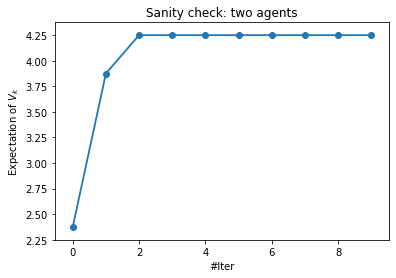

In [60]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 10)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('Expectation of $V_k$')
plt.title("Sanity check: two agents")
plt.show()

In [7]:
policy

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [41]:
def state_generator(graph, n):
    
    node_n = len(graph)
    nS = int(2 + ((node_n - 2)/2) * (n + 1))
    state = np.zeros((nS, len(graph)))
    mark = node_n - 2
    
    # 0
    state[0][0] = n
    
    i = 0 
    m = 1
    for s in range(1, (nS-1)):
        state[s][m] =  i 
        state[s][m+1] = n - i
        i += 1
        if i >= (n+1):
            i = 0 
            m += 2
    state[-1][-1] = 2
    state = state.astype(int)
    return state.tolist()

state = state_generator(graph, 2)
state

[[2, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 0, 0],
 [0, 1, 1, 0, 0, 0],
 [0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0],
 [0, 0, 0, 1, 1, 0],
 [0, 0, 0, 2, 0, 0],
 [0, 0, 0, 0, 0, 2]]

In [36]:
graph = {
    "0": {"1": lambda x : x,            "0": lambda x : 2},
    "1": {"1": lambda x : 1,        "0": lambda x : x},
    "2": {"1": lambda x : 1,        "0": lambda x : x},
    "3": {"1": lambda x : 0.5*x,        "0": lambda x: 3},
    "4": {"1": lambda x : x,           "0": 0},
    "5": {"1": lambda x : 1,            "0": 0},
} 

## Sanity check extension

In [31]:
graph = {
    "0": {"1": lambda x : x,            "0": lambda x : 1},
    "1": {"1": lambda x : 0,            "0": lambda x : x},
    "2": {"1": lambda x : 1,            "0": lambda x : x},
    "3": {"1": lambda x : 5,             "0": lambda x: 3*x},
    "4": {"1": lambda x : 2,            "0": lambda x: x},
    "5": {"1": lambda x : x,            "0": 0},
    "6": {"1": lambda x : 1,            "0": 1},
} 

In [32]:
N = 2
node_N= 6
action = action_generator(N)
state = state_generator2(graph, 2, node_N)
transition = transition_generator(state, action, 2, node_N)
payoff = phi_generator2(state, action, transition, graph, node_N, n = 2)
payoff = -np.array(payoff)


In [33]:
def P_comp(n, node_N):

    nS = int(2 + ((node_N - 2)/2) * (n + 1))
    print(nS)
    nA = 2**n
    P = dict()
    for s in range(nS):
        P[s] = {a : [] for a in range(nA)}

    for state in range(nS):
        for a in range(nA):
            tmp = []
            prob = 1
            snext = transition[state][a]
            reward = payoff[state][a]
            done = False
            if snext == (nS -1):
                done = True
            # prob, next_state, reward, done
            tmp.extend([(prob, int(snext), reward, done)])
            P[state][a] = tmp
            
    return nS, nA, P


In [34]:
nS, nA, P =  P_comp(2, 100)

149


IndexError: index 5 is out of bounds for axis 0 with size 5

In [29]:
policy, V, dl, vl, policy_list, A = value_iteration(100)

NameError: name 'nS' is not defined

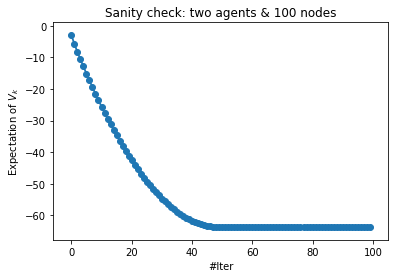

In [58]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 100)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('Expectation of $V_k$')
plt.title("Sanity check: two agents & 100 nodes")
plt.show()

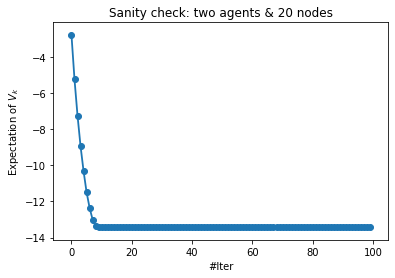

In [65]:
###### plot

v1 = np.array(vl)
x = np.arange(0, 100)
mean_v = np.mean(v1,axis=1) # sum列；得到维度与行维度相同
plt.plot(x, mean_v, linewidth=1.8)
plt.scatter(x, mean_v)
plt.xlabel('#Iter')
plt.ylabel('Expectation of $V_k$')
plt.title("Sanity check: two agents & 20 nodes")
plt.show()

In [ ]:
################################

In [165]:
nS = 149
nA = 4
P = dict()
for s in range(nS):
    P[s] = {a : [] for a in range(nA)}
    
for state in range(nS):
    for a in range(nA):
        tmp = []
        prob = 1
        snext = transition[state][a]
        reward = payoff[state][a]
        done = False
        if snext == 148:
            done = True
        # prob, next_state, reward, done
        tmp.extend([(prob, int(snext), reward, done)])
        P[state][a] = tmp

In [ ]:
# 5 agents; big
# payoff matrix

N = 5
action = action_generator(N)
state = state_generator(N)
payoff = phi_generator(N, state, action, transition)
payoff = -np.array(payoff)
transition = transition_generator(state, action, N)

nS = len(state)
nA = len(action)


In [183]:
action = action_generator(2)
print(len(action))
state = state_generator2(graph, 2, 100)
print(len(state))
transition = transition_generator(state, action, 2, 100)
print(len(transition))
payoff = phi_generator2(2, state, action, transition, graph)
payoff = -np.array(payoff)
print(len(payoff))

4
149
149
149


In [184]:
action

{0: [0, 0], 1: [0, 1], 2: [1, 0], 3: [1, 1]}

In [185]:
state

[[2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0,
  0,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]

In [146]:
len(transition)

149

In [171]:
payoff

array([[ -2.,  -2.,  -2.,  -3.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -9.,  -8.,  -8., -15.],
       [ -3.,  -2.,  -2.,  -2.],
       [ -2.,  -2.,  -1.,  -1.],
       [ -3.,  -1.,  -1.,  -0.],
       [ -4.,  -4.,  -4.,  -4.],
       [ -5.,  -5.,  -7.,  -7.],
       [ -

In [53]:
policy, V, dl, vl, policy_list, A = value_iteration(50)

1
debug-> iter=1, delta=8.00000, V=[-2. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4. -8. -2. -1.  0. -3. -4.
 -8. -2. -2. -3.  0.]
2
debug-> iter=2, delta=5.00000, V=[ -3.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.
  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.
  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.  -4.  -6.  -9.  -6.
  -5.  -5.  -4.  -6.  -9.  -6.  -5.  -5.

  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
16
debug-> iter=16, delta=4.00000, V=[-38. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41.
 -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41.
 -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41.
 -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41.
 -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41.
 -39. -41. -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41.
 -44. -41. -40. -41. -39. -41. -44. -41. -40. -41. -39. -41. -44. -41.
 -40. -41. -40. -42. -45. -38. -37. -38. -35. -37. -40. -33. -32. -33.
 -30. -32. -35. -28. -27. -28. -25. -27. -30. -23. -22. -23. -20. -22.
 -25. -18. -17. -18. -15. -17. -20. -13. -12. -13. -10. -12. -15.  -8.
  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
17
debug-> iter=17, delta=4.00000, V=[-42. -42. -41. -42. -43. -45. -48. -42. -41. -42. -43. -45. -48. -42.
 -41. -42. -43. -45. -48. -42. -41. -42. -43. -45. 

  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
29
debug-> iter=29, delta=4.00000, V=[-72. -72. -71. -72. -73. -75. -78. -72. -71. -72. -73. -75. -78. -72.
 -71. -72. -73. -75. -78. -72. -71. -72. -73. -75. -78. -72. -71. -72.
 -73. -75. -78. -72. -71. -72. -73. -75. -78. -72. -71. -72. -73. -75.
 -78. -72. -71. -72. -73. -75. -78. -72. -71. -72. -73. -75. -78. -72.
 -71. -72. -73. -75. -78. -73. -72. -73. -70. -72. -75. -68. -67. -68.
 -65. -67. -70. -63. -62. -63. -60. -62. -65. -58. -57. -58. -55. -57.
 -60. -53. -52. -53. -50. -52. -55. -48. -47. -48. -45. -47. -50. -43.
 -42. -43. -40. -42. -45. -38. -37. -38. -35. -37. -40. -33. -32. -33.
 -30. -32. -35. -28. -27. -28. -25. -27. -30. -23. -22. -23. -20. -22.
 -25. -18. -17. -18. -15. -17. -20. -13. -12. -13. -10. -12. -15.  -8.
  -7.  -7.  -5.  -6. -10.  -2.  -2.  -3.   0.]
30
debug-> iter=30, delta=4.00000, V=[-73. -76. -75. -76. -74. -76. -79. -76. -75. -76. -74. -76. -79. -76.
 -75. -76. -74. -76. -79. -76. -75. -76. -74. -76. 

43
debug-> iter=43, delta=4.00000, V=[-107. -107. -106. -107. -108. -110. -113. -107. -106. -107. -108. -110.
 -113. -107. -106. -107. -108. -110. -113. -108. -107. -108. -105. -107.
 -110. -103. -102. -103. -100. -102. -105.  -98.  -97.  -98.  -95.  -97.
 -100.  -93.  -92.  -93.  -90.  -92.  -95.  -88.  -87.  -88.  -85.  -87.
  -90.  -83.  -82.  -83.  -80.  -82.  -85.  -78.  -77.  -78.  -75.  -77.
  -80.  -73.  -72.  -73.  -70.  -72.  -75.  -68.  -67.  -68.  -65.  -67.
  -70.  -63.  -62.  -63.  -60.  -62.  -65.  -58.  -57.  -58.  -55.  -57.
  -60.  -53.  -52.  -53.  -50.  -52.  -55.  -48.  -47.  -48.  -45.  -47.
  -50.  -43.  -42.  -43.  -40.  -42.  -45.  -38.  -37.  -38.  -35.  -37.
  -40.  -33.  -32.  -33.  -30.  -32.  -35.  -28.  -27.  -28.  -25.  -27.
  -30.  -23.  -22.  -23.  -20.  -22.  -25.  -18.  -17.  -18.  -15.  -17.
  -20.  -13.  -12.  -13.  -10.  -12.  -15.   -8.   -7.   -7.   -5.   -6.
  -10.   -2.   -2.   -3.    0.]
44
debug-> iter=44, delta=4.00000, V=[-108. -111. -110.

In [ ]:
# 5 agents; big
# payoff matrix

N = 5
action = action_generator(N)
state = state_generator(N)
payoff = phi_generator(N, state, action, transition)
payoff = -np.array(payoff)
transition = transition_generator(state, action, N)

nS = len(state)
nA = len(action)
